<a href="https://colab.research.google.com/github/christianhidber/easyagents/blob/master/jupyter_notebooks/easyagents_orso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Orso's live running on EasyAgents

Make our bear Orso find all the honey in his home turf choosing the most convenient path.  

![Orso](images/Orso.png)


![Orso](images/turf.png)


https://opendatascience.com/bears-need-to-learn-as-well-practical-reinforcement-learning-with-tensorflow-2-0-tf-agents

### Install packages (gym, tfagents, tensorflow,....)

#### suppress package warnings, in colab: load additional packages for rendering

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import warnings

warnings.filterwarnings('ignore')
if 'google.colab' in sys.modules:
    !apt-get install xvfb >/dev/null
    !pip install pyvirtualdisplay >/dev/null    
    
    from pyvirtualdisplay import Display
    Display(visible=0, size=(960, 720)).start() 
else:
    #  for local installation
    sys.path.append('..')

#### install easyagents and rendering for orso

In [2]:
if 'google.colab' in sys.modules:
    !pip install -q easyagents >/dev/null
    !pip install -q networkx==2.3.0 >/dev/null

# Define Gym Environment

In [3]:
import gym
from gym import spaces
import matplotlib.pyplot as plt
import matplotlib.image as mpi
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from IPython.display import display, clear_output
import networkx as nx
import numpy as np
import random

### Orso's Environment (OpenAI Gym)

In [4]:
graph = {
            'S': [('A', 300), ('B', 100), ('C', 200)],
            'A': [('S', 300), ('B', 100), ('E', 100), ('D', 100)],
            'B': [('S', 100), ('A', 100), ('C', 50), ('K', 200)],
            'C': [('S', 200), ('B', 50), ('M', 100), ('L', 200)],
            'D': [('A', 100), ('F', 50)],
            'E': [('A', 100), ('F', 100), ('H', 100)],
            'F': [('D', 50), ('E', 100), ('G', 200)],
            'G': [('F', 200), ('O', 300)],
            'H': [('E', 100), ('K', 300)],
            'K': [('B', 200), ('H', 300)],
            'L': [('C', 200), ('M', 50)],
            'M': [('C', 100), ('L', 50), ('N', 100)],
            'N': [('M', 100), ('O', 100)],
            'O': [('N', 100), ('G', 300)]
        }

def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'H': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C',
        4: 'D',
        5: 'E',
        6: 'F',
        7: 'G',
        8: 'H',
        9: 'K',
        10: 'L',
        11: 'M',
        12: 'N',
        13: 'O'
    }
    return state_map[state_as_int]

class OrsoEnv(gym.Env):
    metadata = {'render.modes': ['ansi']}
    showStep = False

    def __init__(self):
        self.map = graph
        max_paths = 4
        self.action_space = spaces.Discrete(max_paths)

        positions = len(self.map)
        # observations: position, reward of all 4 local paths, rest reward of all locations
        # non existing path is -1000 and no position change
        # look at what #getObservation returns if you are confused
        low = np.append(np.append([0], np.full(max_paths, -1000)), np.full(positions, 0))
        high = np.append(np.append([positions - 1], np.full(max_paths, 1000)), np.full(positions, 1000))
        self.observation_space = spaces.Box(low=low,
                                            high=high,
                                            dtype=np.float32)
        self.reward_range = (-1, 1)
        self.envEpisodeCount = 0
        self.envStepCount = 0
        self._figure = None

        self.reset()
        self.optimum = self.calculate_customers_reward()

        base = "https://raw.githubusercontent.com/christianhidber/easyagents/master/images/"
        self.image_orso = mpi.imread(base + "Bear.png")
        self.image_cave = mpi.imread(base + "Cave.png")
        self.image_honey = mpi.imread(base + "Honey.png")
        self.image_empty_pot = mpi.imread(base + "EmptyPot.png")
        self.nx_graph, self.nx_pos = self._create_nx_graph()

    def iterate_path(self, state, action):
        paths = self.map[state]
        if action < len(paths):
            return paths[action]
        else:
            # sorry, no such action, stay where you are and pay a high penalty
            return (state, 1000)

    def step(self, action):
        destination, cost = self.iterate_path(self.state, action)

        self.cost = cost
        self.action = action
        self.lastStep_state = self.state
        self.state = destination
        self.customerReward = self.customer_reward[destination]
        self.reward = 0
        self.reward = (self.customerReward - self.cost) / self.optimum

        self.customer_visited(destination)
        done = (destination == 'S' and self.all_customers_visited())

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += self.reward
        self.stepCount += 1
        self.envStepCount += 1

        if done and not self.isDone:
            self.envEpisodeCount += 1

        self.isDone = done
        observation = self.getObservation(stateAsInt)
        info = {"from": self.state, "to": destination}
        return observation, self.reward, done, info

    def getObservation(self, position):
        result = np.array([position,
                           self.getPathObservation(position, 0),
                           self.getPathObservation(position, 1),
                           self.getPathObservation(position, 2),
                           self.getPathObservation(position, 3)
                           ],
                          dtype=np.float32)
        all_rest_rewards = list(self.customer_reward.values())
        result = np.append(result, all_rest_rewards)
        return result

    def getPathObservation(self, position, path):
        paths = self.map[self.state]
        if path < len(paths):
            target, cost = paths[path]
            reward = self.customer_reward[target]
            result = reward - cost
        else:
            result = -1000

        return result

    def customer_visited(self, customer):
        self.customer_reward[customer] = 0

    def all_customers_visited(self):
        return self.calculate_customers_reward() == 0

    def calculate_customers_reward(self):
        sum = 0
        for value in self.customer_reward.values():
            sum += value
        return sum

    def modulate_reward(self):
        number_of_customers = len(self.map) - 1
        number_per_consultant = int(number_of_customers / 2)
        self.customer_reward = {
            'S': 0
        }
        self._honeypot_places = []
        for customer_nr in range(1, number_of_customers + 1):
            self.customer_reward[int_to_state_name(customer_nr)] = 0

        # every consultant only visits a few random customers
        samples = random.sample(range(1, number_of_customers + 1), k=number_per_consultant)
        key_list = list(self.customer_reward.keys())
        for sample in samples:
            self.customer_reward[key_list[sample]] = 1000
            self._honeypot_places = self._honeypot_places + [key_list[sample]]

    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False
        self.state = 'S'
        self.cost = 0
        self.action = 0
        self.lastStep_state = ''
        self.customerReward = None
        self._honeypot_places = None
        self.reward = 0
        self.envEpisodeCount += 1
        self.modulate_reward()
        self._figure = None
        return self.getObservation(state_name_to_int(self.state))

    def _create_nx_graph(self):
        """ generates the networkx graph representing orso's world with all its paths.

        :return: graph, positions
        """
        nx_graph = nx.Graph()
        for node_id in self.map.keys():
            zoom = 0.6
            image = self.image_empty_pot
            nx_graph.add_node(node_id, image=image, zoom=zoom)
        for source, connections in self.map.items():
            for target, cost in connections:
                if cost >= 300:
                    color = 'dodgerblue'
                elif cost >= 200:
                    color = 'darkgoldenrod'
                elif cost >= 100:
                    color = 'forestgreen'
                else:
                    color = 'greenyellow'
                nx_graph.add_edge(source, target, color=color, weight=6, image=self.image_cave)
        nx_pos = nx.kamada_kawai_layout(nx_graph)
        return nx_graph, nx_pos

    def _render_to_figure(self):
        """ Renders the current state as a graph with matplotlib
        """
        # draw graph using matplotlib
        if (self._figure is not None):
            plt.close(self._figure)
        self._figure = plt.figure("BeraterEnv", figsize=(12, 9))
        if len(self._figure.axes) == 0:
            self._figure.add_subplot(1, 1, 1)
        self._figure.axes[0].cla()
        ax = self._figure.axes[0]

        edges = self.nx_graph.edges()
        edge_colors = [self.nx_graph[u][v]['color'] for u, v in edges]
        edge_weights = [self.nx_graph[u][v]['weight'] for u, v in edges]
        nx.draw(self.nx_graph, pos=self.nx_pos, ax=ax, node_color='lightgrey',
                edges=edges, edge_color=edge_colors, width=edge_weights, with_labels=True)

        # draw images on graph nodes
        # set image (according to the current state) and sizes (make orso's current position larger)
        for node_id in self.nx_graph.nodes():
            node = self.nx_graph.node[node_id]
            node['zoom'] = 0.4
            if node_id == self.state:
                node['zoom'] = 0.6
            if node_id in self._honeypot_places:
                node['image'] = self.image_empty_pot
                if self.customer_reward[node_id] > 0:
                    node['image'] = self.image_honey
            else:
                node['image'] = None
            if node_id == 'S':
                node['image'] = self.image_cave
            if self.state == node_id:
                node['image'] = self.image_orso

        # position images
        for n in self.nx_pos:
            node = self.nx_graph.node[n]
            image = node['image']
            if image is not None: 
                xp, yp = self.nx_pos[n]
                offset_image = OffsetImage(image, node['zoom'])
                offset_image.image.axes = ax
                ab = AnnotationBbox(offset_image, (xp, yp),
                                    xybox=(0, 0),
                                    xycoords='data',
                                    boxcoords="offset points",
                                    pad=0.0,
                                    frameon=False
                                    )
                ax.add_artist(ab)

        self._figure.canvas.draw()

    def _render_ansi(self):
        result = ("Episode: " + ("%4.0f  " % self.envEpisodeCount) +
                  " Step: " + ("%4.0f  " % self.stepCount) +
                  self.lastStep_state + ' --' + str(self.action) + '-> ' + self.state +
                  ' R=' + ("% 2.2f" % self.reward) + ' totalR=' + ("% 3.2f" % self.totalReward) +
                  ' cost=' + ("%4.0f" % self.cost) + ' customerR=' + ("%4.0f" % self.customerReward) + ' optimum=' + (
                          "%4.0f" % self.optimum)
                  )
        return result

    def _render_rgb(self):
        self._render_to_figure()
        self._figure.canvas.draw()
        buf = self._figure.canvas.tostring_rgb()
        num_cols, num_rows = self._figure.canvas.get_width_height()
        plt.close(self._figure)
        self._figure = None
        result = np.fromstring(buf, dtype=np.uint8).reshape(num_rows, num_cols, 3)
        return result

    def render(self, mode='human'):
        if mode == 'ansi':
            return self._render_ansi()
        elif mode == 'human':
            clear_output(wait=True)
            self._render_to_figure()
            plt.pause(0.01)
            return
        elif mode == 'rgb_array':
            return self._render_rgb()
        else:
            super().render(mode=mode)
          

# First Steps

Orso - the bear - lives in his cave (position 'S'). Orso knows his area and where he can 
typically find some honey (positions 'A' to 'O'). The honey places are scattered all over his home turf and connected
by some pathways. Some connections are easy like walking over a grassy field (light green, very low cost) or forests 
(dark green, low cost), a bit strenuous like walking over a hill (brown, higher costs) and very arduous like swimming 
through a lake (blue, very high costs).

There are other bears around competing for the honey pots. So some spots have honey (yellow nodes) and some
are already taken (brown nodes).

Every morning, Orso awakes and starts looking for some honey. But every day, the honey pots are at a new place
( env.reset() ). So Orso climbs a tree near his cave to find out where the honey is. Even with this knowledge it is not clear which route he should take. Being a bear also means being lazy, so Orso wants to get as much honey as possible while at the lowest costs possible. At each spot he has to decide where to go next (the action). His daily journey ends when his back in his own cave.

Be god and create Orso's world:

In [5]:
env = OrsoEnv()

A new morning starts (rerun the cell below to see how the honey pots change places). But Orso 
(depicted in 'fuchsia', Marsha's favorite color ?) doesn't know 
about the sweetness of honey or his surroundings. So the climbs a tree to get an overview and this is what he sees:

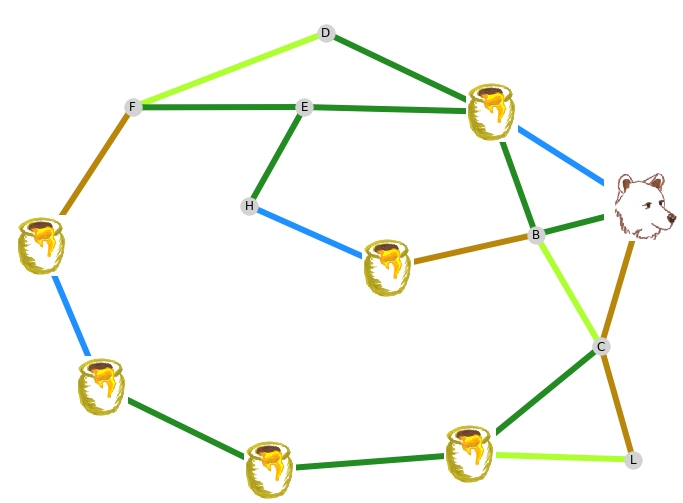

In [6]:
env.render() 

Take Orso by his paws and go for a few steps:

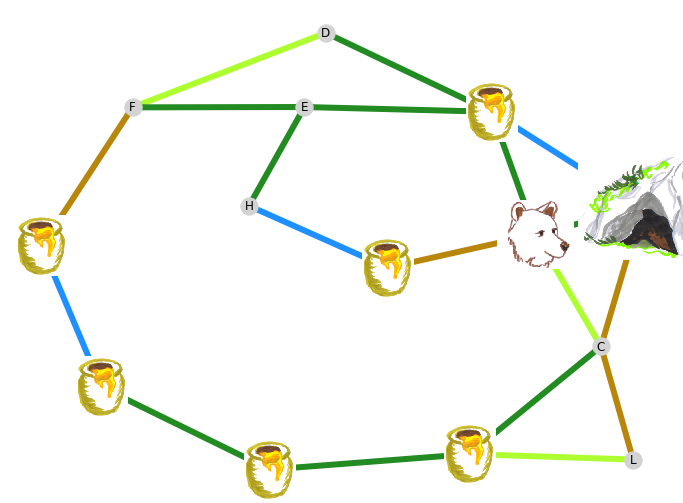

Episode:    1   Step:    1  S --1-> B R=-0.02 totalR=-0.02 cost= 100 customerR=   0 optimum=6000


In [7]:
env.step(1)
env.render()
print(env.render(mode='ansi'))

Note that the honey pots become empty once Orso has passed and taken the honey.

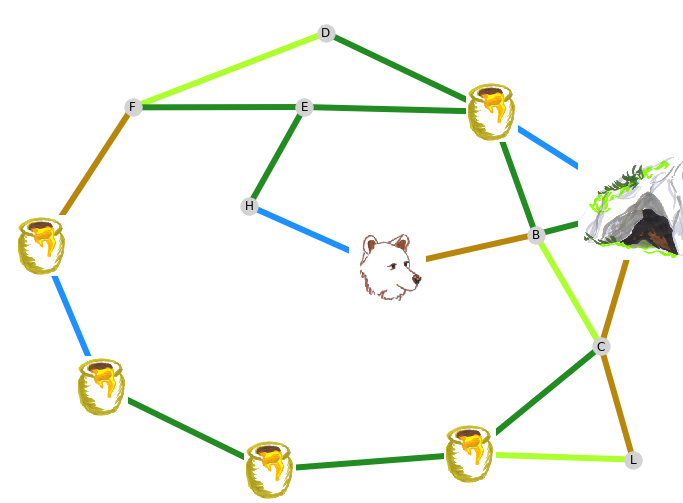

Episode:    1   Step:    2  B --3-> K R= 0.13 totalR= 0.12 cost= 200 customerR=1000 optimum=6000


In [8]:
env.step(3)
env.render()
print(env.render(mode='ansi'))

Now Orso must start to learn by himself to take actions to gather all the honey while minimizing the effort:

### Register with OpenAI Gym

In [9]:
from easyagents.env import register_with_gym

register_with_gym("Orso-v1", OrsoEnv, max_episode_steps=100)


  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  




Using TensorFlow backend.


# Orso's random walk

Let's see how well Orso performs when just walking around randomly:

In [10]:
from easyagents.agents import RandomAgent
from easyagents.callbacks import plot

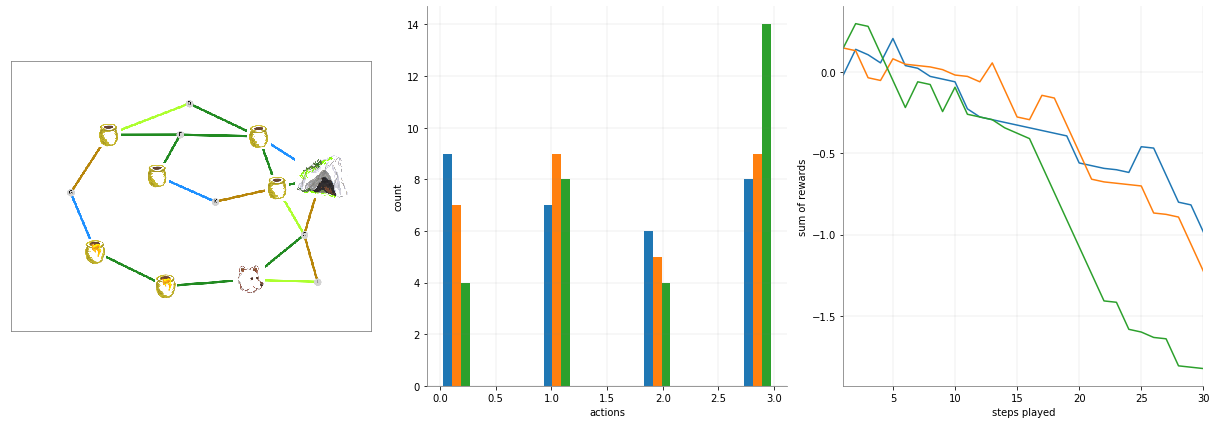

In [11]:
rndAgent = RandomAgent('Orso-v1')

rndAgent.play([plot.State(),plot.Actions(), plot.StepRewards()], num_episodes=3, max_steps_per_episode=30)

The right plot shows how the sum of rewards evolves for a couple of different episodes using a random policy. Clearly Orso is running around erratically accumulating negative rewards while having difficulties in finding back to his cave (max_steps_per_episodes = 100 by default). 

# Train policy with PpoAgent

##  Custom plots

In [ ]:
from easyagents.agents import PpoAgent
from easyagents.callbacks import log, plot, duration

In [ ]:
ppoAgent = PpoAgent('Orso-v1', fc_layers=(500,500,500))

ppoAgent.train([plot.State(), plot.Loss(), plot.Rewards(ylim=(-5,0.8)), plot.Actions(),  
                plot.Steps(), duration.Fast()])

From the plot of the last evaluation episodes final state, we see that Orso typically finds some of the honey pots. The histogram shows that Orso almost always takes action 0. Not a very clever strategy. More training is needed.

## Custom training (duration, learning rate)

In [ ]:
from easyagents.agents import PpoAgent
from easyagents.callbacks import plot

In [ ]:
%%time

ppoAgent = PpoAgent( 'Orso-v1',fc_layers=(500,500,500))

ppoAgent.train([plot.State(),   plot.Loss(),        plot.Rewards(), 
                plot.Actions(), plot.StepRewards(), plot.Steps()], 
                learning_rate = 0.0001, num_iterations = 500, max_steps_per_episode=50 )

Some points to observe:
* Note from the histogram that Orso initially is stuck with action 0. As the training proceeds the other actions are also discovered, resulting on average in shorter episodes and more rewards. 
* Also the state plot (rendering the state of the last evaluation episodes last step) shows that Orso starts to find more honey pots and its way back home. 
* Note that action 3 is less likely than the other actions. That's because we only have a few positions with 3 or more valid directions but all positions have at least 2 directions.

## Play & turn ouput into a movie

In [ ]:
from easyagents.agents import PpoAgent
from easyagents.callbacks import plot

In [ ]:
ppoAgent.play([plot.State(), plot.StepRewards(num_steps_between_plot=1), plot.Actions(), plot.ToMovie(fps=3)], 
              num_episodes=5, max_steps_per_episode=20)

Play uses the previously trained policy. We play for 5 episodes, each with max 20 steps. All steps are rendered into a movie with a frame rate of 3 steps per second.


## Discovering & Switching backends

EasyAgents does not implement algorithms like Ppo or Dqn by itself. Instead it relies on existig implementations and offers an 'easy' access offering the same api across all implementations. We call these implementations a 'backend'. So far we did not choose a backend explicitely, thus a 'default' algorithm implementation was chosen automatically. However we can readily discover the available backends ike this: 

In [10]:
import easyagents

easyagents.agents.get_backends()

['default', 'tfagents', 'tensorforce', 'kerasrl']

Currently the default implementation of PpoAgent uses 'tfagents'. 
To use 'tensorforce' instead set the 'backend' argument:

In [11]:
from easyagents.agents import PpoAgent
from easyagents.callbacks import plot

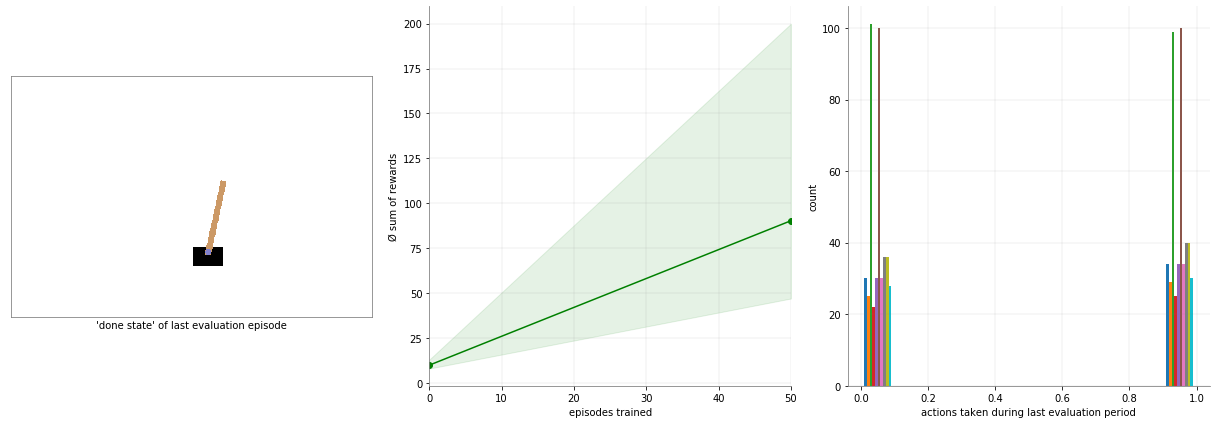

In [28]:
easyagents.callbacks.plot.on_train_end_clear_jupyter_display=True
ppoAgent = PpoAgent( 'CartPole-v0', backend='tensorforce')

ppoAgent.train([plot.State(), plot.Rewards(),plot.Actions()], num_iterations = 5 )

There are differences between the implementations. 
Thus you may (and probably will) get different results, depending on your particular backend choice. 
The current 'tensorforce' backend implementation does not provide the losss, thus we do not display 
the loss plot.

Not all backends implement all algorithms. To discover the admissible backends for a particular agent,
pass the agent to get_backends:

In [5]:
import easyagents
from easyagents.agents import RandomAgent

easyagents.agents.get_backends(RandomAgent)


['default', 'tfagents', 'tensorforce']

## Next: logging, seeding & plot clearing

*  see [on colab](https://colab.research.google.com/github/christianhidber/easyagents/blob/master/jupyter_notebooks/easyagents_logging.ipynb):
  Investigate how an agents api and how it interacts with the gym environment; 
  how to set seeds; controlling jupyter output cell clearing